## Group Presentation 6
### Retail Store Demand Forecasting

Group members:

- Jiho Jun - 9080800
- Edwin Lopez - 9055061
- Vishnu Sivaraj - 9025320
 

Objective  
Explore historical retail store data and check how past sales and promotion signals relate to demand one week ahead.

Hypotheses  

- **Null hypothesis (H₀)**: Past sales and promotions do not add significant predictive signal for next week product demand.  
- **Alternative hypothesis (Hₐ)**: Past sales and promotions add significant predictive signal for next week product demand.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


## Load Dataset

In [13]:
df = pd.read_csv("data/retail_store_inventory.csv")
print(df.head())

# Shape and info
print("Dataset shape:", df.shape)
print(df.info())

# Missing values
print(df.isnull().sum())

         Date Store ID Product ID     Category Region  Inventory Level  \
0  2022-01-01     S001      P0001    Groceries  North              231   
1  2022-01-02     S001      P0001    Groceries   West              116   
2  2022-01-03     S001      P0001  Electronics   West              154   
3  2022-01-04     S001      P0001    Groceries  South               85   
4  2022-01-05     S001      P0001    Groceries  South              238   

   Units Sold  Units Ordered  Price  Discount Weather Condition  \
0         127             55  33.50        20             Rainy   
1          81            104  27.95        10            Cloudy   
2           5            189  62.70        20             Rainy   
3          58            193  77.88        15            Cloudy   
4         147             37  28.46        20             Sunny   

   Holiday/Promotion  Competitor Pricing Seasonality  
0                  0               29.69      Autumn  
1                  0               30.89  

In this part we have successfully loaded our dataset and print the first few rows, which confirm we have daily data at the store–product level. For each date, we see the product category, region, inventory level, sales (Units Sold), orders placed, pricing, discount, weather, and whether there was a holiday or promotion.  

The dataset is fairly large with 73,100 rows and 14 columns, and `info()` shows there are no missing values in any column. This is a good starting point because we don’t need to perform any imputation before modeling. The mix of numeric and categorical fields will allow us to explore how operational factors (inventory, price, discount) and external factors (weather, seasonality, promotions) relate to demand.

EDA

In [3]:
print(df.describe())

       Inventory Level    Units Sold  Units Ordered         Price  \
count     73100.000000  73100.000000   73100.000000  73100.000000   
mean        274.469877    136.464870     110.004473     55.135108   
std         129.949514    108.919406      52.277448     26.021945   
min          50.000000      0.000000      20.000000     10.000000   
25%         162.000000     49.000000      65.000000     32.650000   
50%         273.000000    107.000000     110.000000     55.050000   
75%         387.000000    203.000000     155.000000     77.860000   
max         500.000000    499.000000     200.000000    100.000000   

           Discount  Holiday/Promotion  Competitor Pricing  
count  73100.000000       73100.000000        73100.000000  
mean      10.009508           0.497305           55.146077  
std        7.083746           0.499996           26.191408  
min        0.000000           0.000000            5.030000  
25%        5.000000           0.000000           32.680000  
50%       10


These summary statistics show typical ranges and central values for our key numeric variables:

- Inventory Level averages around 274 units per product in a day, with most values between about 162 and 387, and a maximum of 500 units.  
- Units Sold has a median of 107 units and a wide spread (standard deviation ~109), meaning demand varies a lot from day to day.  
- Units Ordered has a median of 110, roughly matching Units Sold, which is consistent with regular replenishment.  
- Price ranges from 10 to 100, with a median of about 55.  
- Discount is usually between 0% and 20%, with a typical discount of 10%.  
- Holiday/Promotion is a binary flag, and its mean ~0.50 tells us that promotion and non‑promotion days are almost evenly split.  
- Competitor Pricing has a similar range and average to our own Price

## Target Distribution


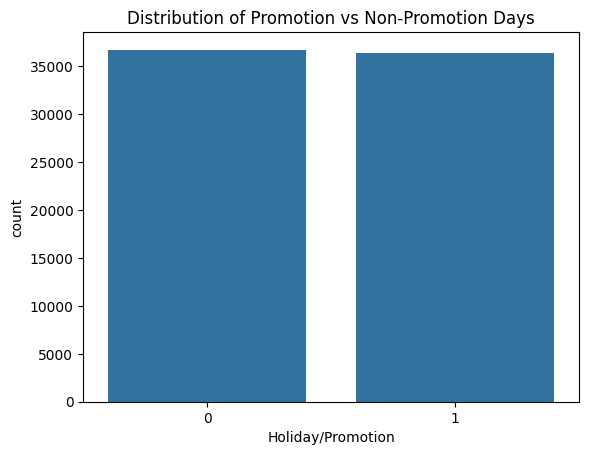

In [4]:
sns.countplot(x="Holiday/Promotion", data=df)
plt.title("Distribution of Promotion vs Non-Promotion Days")
plt.show()


This bar chart compares how many days in our dataset are promotion days (Holiday/Promotion = 1) versus non promotion days (0). The two bars are almost the same height, meaning the data is very balanced we have roughly half promotion days and half regular days.  

This balance is helpful for our analysis. It means we have enough examples of both situations to learn how promotions affect demand, and the model will not be biased toward either always promotion or never promotion scenarios.

## Correlation Heatmap

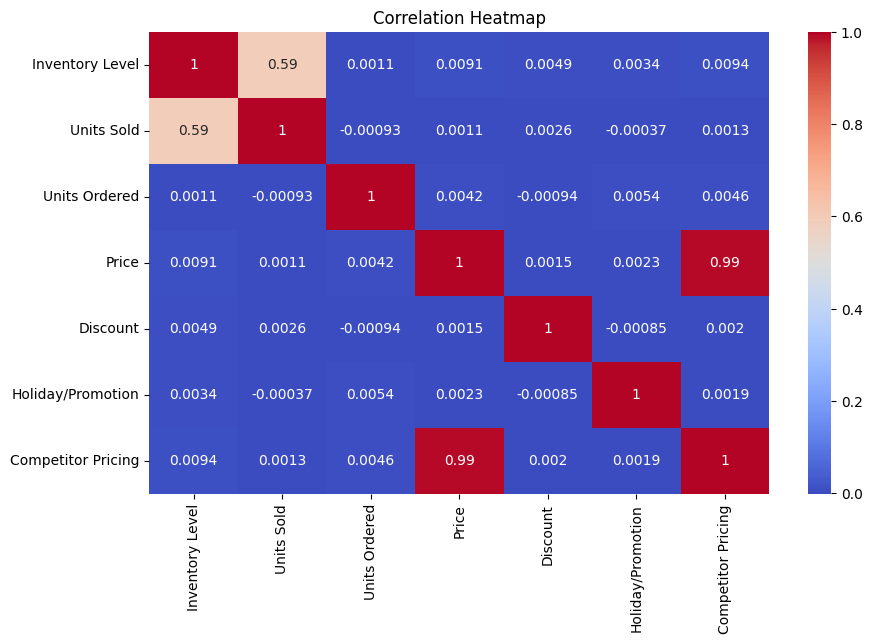

In [5]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

This heatmap shows how strongly each numeric variable is linearly related to the others,

- The main noticeable relationship is between Inventory Level and Units Sold (correlation ≈ 0.59). This suggests that products with higher inventory tend to sell more units, which makes sense because stores keep more stock of faster moving items.  
- Price and Competitor Pricing have an extremely high correlation (≈ 0.99), meaning both carry nearly the same information. To avoid redundancy and unstable coefficients, we later drop Competitor Pricing from our model and keep only our own Price.  
- All other correlations are very close to zero, indicating that Units Ordered, Discount, Holiday/Promotion and the rest are not strongly linearly correlated with each other or with Units Sold at the global level. This doesn’t mean they are useless but it suggests their effects are more subtle and will be better captured by the logistic model rather than simple pairwise correlations.

## Feature Exploration


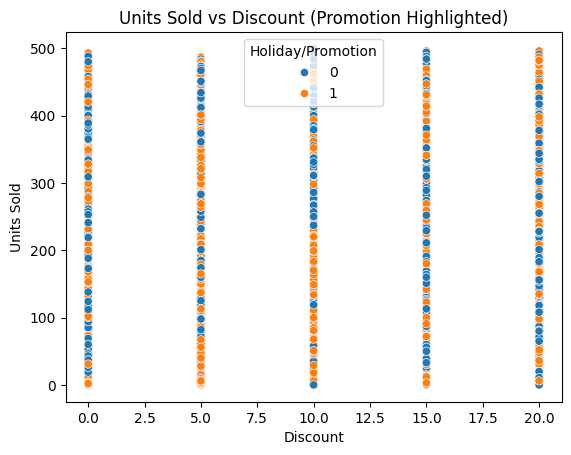

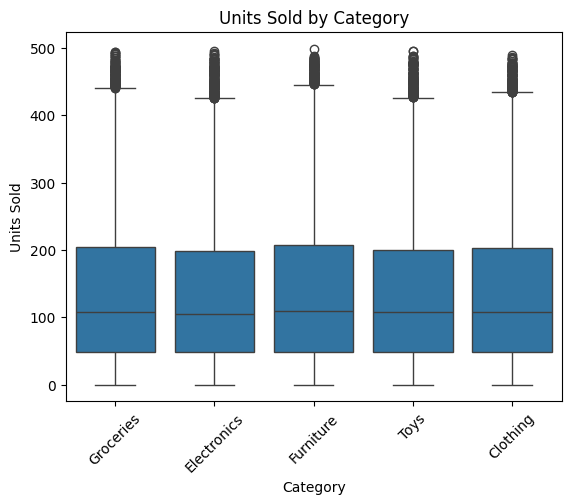

In [6]:
# Units Sold vs Discount
sns.scatterplot(x="Discount", y="Units Sold", hue="Holiday/Promotion", data=df)
plt.title("Units Sold vs Discount (Promotion Highlighted)")
plt.show()

# Category vs Units Sold
sns.boxplot(x="Category", y="Units Sold", data=df)
plt.title("Units Sold by Category")
plt.xticks(rotation=45)
plt.show()

Units Sold vs Discount (with promotion highlighted)

This scatter plot shows how daily Units Sold varies across different discount levels, with color indicating whether there was a promotion. The vertical bands appear at 0, 5, 10, 15 and 20, which are the discrete discount values used in the data. Within each band, sales values are spread widely from very low to very high, so discount alone does not fully explain demand. We also see both promotion (orange) and non‑promotion (blue) points at all discount levels, meaning promotions and discounts are not perfectly tied together.

Units Sold by Category (boxplot)

This boxplot compares the distribution of daily Units Sold across product categories. All categories show a wide range of sales, with many outliers at the high end, which indicates that every category can have very strong demand days. The medians are relatively similar, but Furniture and Toys appear to have slightly higher central values and wider boxes, which suggests they may be a bit more volatile in sales compared to Groceries or Clothing.

## 1. Logistic Classification


In this part we are implementing Logistic classification in a way that directly supports our project’s purpose: predicting demand one week ahead based on past sales and promotion signals.

Instead of just predicting Holiday/Promotion, we’ll reframe the target to High vs. Low Demand. This best alligns with our hypothesis: past sales and promotions add predictive signal for next week’s demand.

For this to be done we'll begin by creating a binary target which is,

1 = High Demand (Units Sold > median)
0 = Low Demand (Units Sold ≤ median)




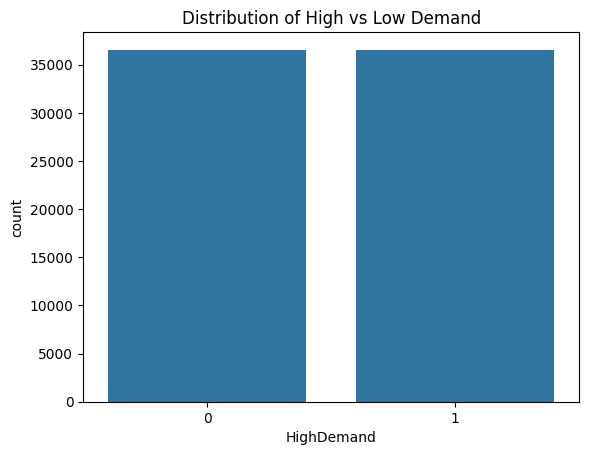

Median Units Sold: 107.0
Class proportions:
 HighDemand
0    0.500109
1    0.499891
Name: proportion, dtype: float64


In [7]:
# --- CREATE BINARY TARGET: HIGH VS LOW DEMAND ---
median_units = df["Units Sold"].median()
df["HighDemand"] = (df["Units Sold"] > median_units).astype(int)

# Check distribution
sns.countplot(x="HighDemand", data=df)
plt.title("Distribution of High vs Low Demand")
plt.show()

print("Median Units Sold:", median_units)
print("Class proportions:\n", df["HighDemand"].value_counts(normalize=True))

Here we convert the continuous variable Units Sold into a binary target, HighDemand. Any day with Units Sold above the median is labeled as 1 (high demand); otherwise it is labeled 0 (low demand).

The bar chart shows that the two classes are almost perfectly balanced, there are roughly as many high demand days as low demand days. This is ideal for our logistic regression model, because it avoids a class imbalance problem and ensures that accuracy, precision, and recall will be meaningful and not dominated by one majority class.

### Prepare Features


In [8]:
# --- DROP IRRELEVANT / UNWANTED COLUMNS ---
cols_to_drop = [
    "Date",
    "Store ID",
    "Product ID",
    "Units Sold",          # original numeric target
    "Competitor Pricing",  # highly collinear with Price
    "Category"             # remove Category so no category_* features appear
]

# keep only columns that exist
cols_to_drop = [c for c in cols_to_drop if c in df.columns]
df_cleaned = df.drop(columns=cols_to_drop)

print("Columns after dropping IDs, Units Sold, Competitor Pricing, and Category:")
print(df_cleaned.columns)

Columns after dropping IDs, Units Sold, Competitor Pricing, and Category:
Index(['Region', 'Inventory Level', 'Units Ordered', 'Price', 'Discount',
       'Weather Condition', 'Holiday/Promotion', 'Seasonality', 'HighDemand'],
      dtype='object')


In this step we simplify the dataset to keep only the variables that are useful and safe for modeling,

We drop Date, Store ID, and Product ID because they are identifiers and do not directly explain demand.
We remove Units Sold because it is the original continuous target, now replaced by our binary HighDemand label.
We drop Competitor Pricing since it is almost perfectly correlated with our own Price and would add redundant information.
We also remove Category so that no Category dummy variables appear in the model.

In [9]:
# --- ONE-HOT ENCODE CATEGORICAL VARIABLES (EXCLUDING CATEGORY) ---
# After dropping Category, remaining categoricals are: Region, Weather Condition, Seasonality
df_encoded = pd.get_dummies(df_cleaned, drop_first=True)

# Separate features and target
X = df_encoded.drop(columns=["HighDemand"])
y = df_encoded["HighDemand"]

print("Feature matrix shape:", X.shape)
print("Some feature names:", X.columns[:15].tolist())

Feature matrix shape: (73100, 14)
Some feature names: ['Inventory Level', 'Units Ordered', 'Price', 'Discount', 'Holiday/Promotion', 'Region_North', 'Region_South', 'Region_West', 'Weather Condition_Rainy', 'Weather Condition_Snowy', 'Weather Condition_Sunny', 'Seasonality_Spring', 'Seasonality_Summer', 'Seasonality_Winter']


Here we convert the remaining categorical variables (Region, Weather Condition, Seasonality) into numerical dummy variables using one‑hot encoding. Because we set `drop_first=True`, each category is represented by k‑1 dummy columns, which avoids perfect collinearity.  

The resulting feature matrix has 14 columns and no Category or Competitor Pricing variables. Our model will now learn from a mix of numeric features (Inventory Level, Units Ordered, Price, Discount, Holiday/Promotion) and dummy indicators for regions, weather conditions, and seasonal effects. This gives the logistic regression enough information to capture both operational and contextual influences on demand.

### Train-Test Split 

Our next step is to split the dataset into training and testing sets to evaluate model performance fairly.



In [14]:

# --- TRAIN-TEST SPLIT ---
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25,       # 25% of data for testing
    random_state=42,      # reproducibility
    stratify=y            # keep class distribution balanced
)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

# --- STANDARDIZE ALL FEATURES (INCLUDING CATEGORICAL) ---
from sklearn.preprocessing import StandardScaler

# Create and fit scaler ONLY on training data
scaler = StandardScaler()

# Fit on ALL training features (continuous + binary dummies)
scaler.fit(X_train)  # This learns mean and std for EVERY column

# Transform both sets using the SAME learned parameters
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames to maintain column names
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Verify standardization
print("\nVerification - First 3 features of first training sample:")
for i, col in enumerate(X_train.columns[:3]):
    print(f"  {col}: {X_train.iloc[0, i]:.4f}")

Training set size: 54825
Testing set size: 18275

Verification - First 3 features of first training sample:
  Inventory Level: 0.1033
  Units Ordered: 1.5701
  Price: 1.3309


We split the data into a training set (54,825 rows) and a testing set (18,275 rows), using a 75/25 split. The `stratify=y` option keeps the proportion of high‑ and low‑demand days the same in both sets, so evaluation on the test set is fair and comparable to the training distribution.  

Next, we standardize all features using `StandardScaler`. The scaler is fit only on the training data to avoid data leakage, then applied to both train and test. After scaling, each feature has mean close to 0 and standard deviation close to 1. This helps the logistic regression algorithm converge faster and makes the coefficients easier to compare across features.

## Logistic Regression Implementation
Now that we are all set to train the model and evaluate it, in this step we are going to 
- Train the model using the prepared features.  
- Evaluate using accuracy, precision, recall, and a confusion matrix


Accuracy: 0.7106429548563612

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71      9140
           1       0.71      0.71      0.71      9135

    accuracy                           0.71     18275
   macro avg       0.71      0.71      0.71     18275
weighted avg       0.71      0.71      0.71     18275



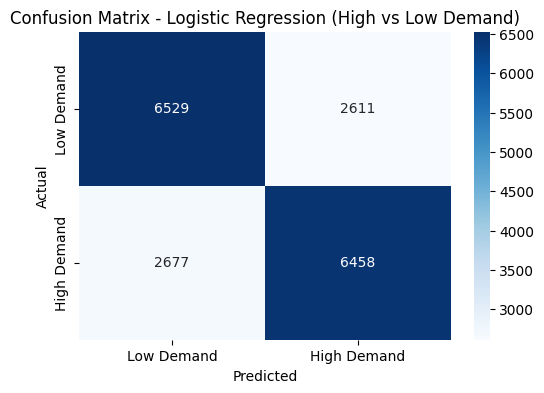

In [11]:
# Train Logistic Regression Model
log_reg = LogisticRegression(max_iter=1000)

# Fit the model
log_reg.fit(X_train, y_train)

# Predictions on test set
y_pred = log_reg.predict(X_test)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Low Demand","High Demand"], 
            yticklabels=["Low Demand","High Demand"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (High vs Low Demand)")
plt.show()

The logistic regression model correctly classifies about 71% of the days as high or low demand. Because the classes are balanced, this accuracy is meaningful and not driven by one majority class.

From the classification report

- For low demand (class 0), precision and recall are both 0.71.  
- For high demand (class 1), precision and recall are also 0.71.  

This symmetry means the model treats both classes fairly, it is equally good at finding high demand days and low demand days.

Looking at the confusion matrix,

- True negatives (6529): low‑demand days correctly predicted as low.  
- True positives (6458): high‑demand days correctly predicted as high.  
- False positives (2611): predicted high demand but actual demand was low (potential over stocking).  
- False negatives (2677): predicted low demand but actual demand was high (risk of stock outs).

From a business point of view, false negatives are often more costly because they represent missed high demand days where we might run out of stock. Overall, a 71% accuracy with balanced precision and recall shows that past inventory, ordering, price, discounts, promotions, weather, and seasonality contain useful predictive signal for demand classification.

                    Feature  Coefficient  AbsCoefficient
0           Inventory Level     1.181040        1.181040
12       Seasonality_Summer    -0.024926        0.024926
11       Seasonality_Spring    -0.015195        0.015195
2                     Price    -0.013334        0.013334
5              Region_North    -0.011248        0.011248
3                  Discount     0.008910        0.008910
13       Seasonality_Winter    -0.008308        0.008308
1             Units Ordered    -0.006790        0.006790
9   Weather Condition_Snowy    -0.005348        0.005348
4         Holiday/Promotion     0.004224        0.004224
7               Region_West    -0.003243        0.003243
6              Region_South    -0.002887        0.002887
10  Weather Condition_Sunny     0.002364        0.002364
8   Weather Condition_Rainy     0.000871        0.000871


C:\Users\Vishnu\AppData\Local\Temp\ipykernel_1536\828050577.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=coef_df_sorted.head(15), palette="coolwarm")


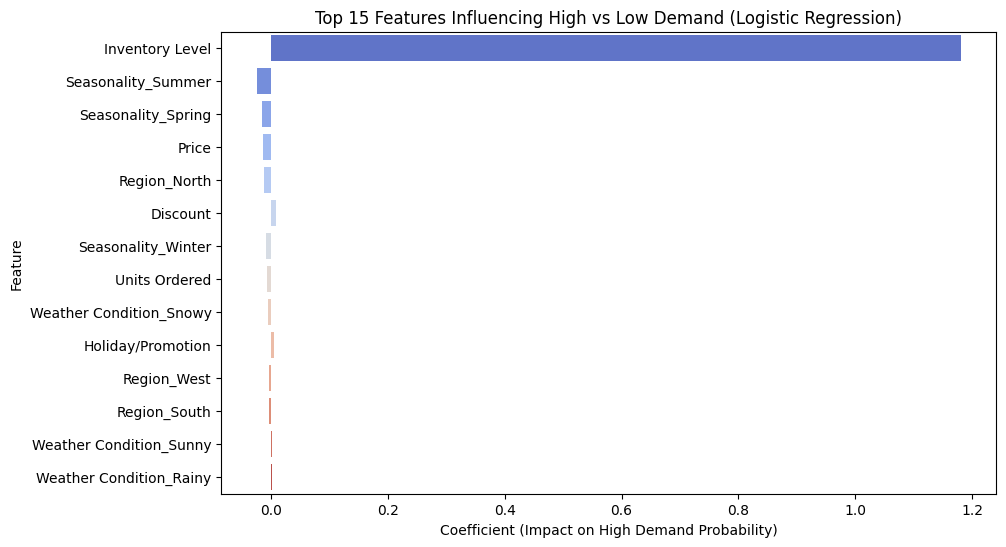

In [12]:
# Feature Importance (Coefficients)

# Get feature names
feature_names = X_train.columns

# Extract coefficients from the trained logistic regression model
coefficients = log_reg.coef_[0]

# Create a DataFrame for easy viewing
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})

# Sort by absolute value of coefficient (strongest impact first)
coef_df["AbsCoefficient"] = coef_df["Coefficient"].abs()
coef_df_sorted = coef_df.sort_values(by="AbsCoefficient", ascending=False)

# Display top 15 most influential features
print(coef_df_sorted.head(15))

# Plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(x="Coefficient", y="Feature", data=coef_df_sorted.head(15), palette="coolwarm")
plt.title("Top 15 Features Influencing High vs Low Demand (Logistic Regression)")
plt.xlabel("Coefficient (Impact on High Demand Probability)")
plt.ylabel("Feature")
plt.show()


This plot shows the 15 features with the strongest impact on the probability of high demand, after all features have been standardized.

- 'Inventory Level' stands out with the largest positive coefficient (~1.18). This means that, holding everything else constant, days with higher inventory are much more likely to be classified as high‑demand days. In practice, this suggests stores tend to keep more stock on items that sell well.  
- Seasonal dummies (Seasonality_Summer, Seasonality_Spring, Seasonality_Winter) have small negative coefficients, indicating slightly lower odds of high demand. These effects are weak but show some seasonal pattern.  
- Price has a small negative coefficient, meaning higher prices are associated with a slightly lower probability of high demand, as expected.  
- Discount has a small positive effect: larger discounts slightly increase the chance of a high demand day.  
- Units Ordered has a small negative coefficient, suggesting that, after controlling for inventory and other factors, placing more orders is mildly associated with lower probability of that particular day being a high demand day
- Region and Weather Condition coefficients are close to zero, so location and daily weather have only minor direct influence compared to inventory and pricing in this model.  

Overall, the model suggests that internal operational variables especially Inventory Level and, to a lesser extent, Price and Discount are far more influential for distinguishing high vs. low demand than region, weather, or seasonality.